In [2]:
from sympy import *
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
import multiprocessing as mp

In [3]:
from MD_Parser import *

### Define helper functions.

In [4]:
# get two body kernel (two derivatives)
# x1, x2 are 4xN matrices containing distances and Cartesian coordinate differences
def tb_kern(x1, x2, d1, d2, sig, ls):
    # loop over atoms
    tot_kern = 0
    for m in range(x1.shape[1]):
        dist1 = x1[0,m]
        coord1 = x1[d1,m]
        for n in range(x2.shape[1]): 
            dist2 = x2[0,n]
            coord2 = x2[d2,n]
            
            # calculate covariance for current pair of atoms
            base = sig**2*np.exp(-(dist1-dist2)**2/(2*ls**2))
            doub_fac = -ls**2+(dist1-dist2)**2
            kern = -base*coord1*coord2*doub_fac/(dist1*dist2*ls**4)
            
            tot_kern+=kern

    return tot_kern

# get 3Nx3N noiseless kernel matrix
# assume all 3 force components are known for each configuration
# X is assumed to be a list of 4xN arrays
def get_K(X,sig,ls,noise):
    # initialize matrix
    size = len(X)*3
    K = np.zeros([size, size])
    
    # calculate elements
    for m in range(size):
        x1 = X[int(floor(m/3))]
        d1 = m%3+1
        for n in range(m,size):
            x2 = X[int(floor(n/3))]
            d2 = n%3+1
           
            # calculate kernel
            cov = tb_kern(x1, x2, d1, d2, sig, ls)
            K[m,n] = cov
            K[n,m] = cov
    # perform cholesky decomposition
    L = np.linalg.cholesky(K+noise**2*np.eye(size))
    
    return K, L

# get row of covariances
def get_cov_row(x1, d1, m, size, X, sig, ls):
    covs = []
    for n in range(m,size):
        x2 = X[int(floor(n/3))]
        d2 = n%3+1

        # calculate kernel
        cov = tb_kern(x1, x2, d1, d2, sig, ls)
        covs.append(cov)
        
    return covs

# get covariance matrix with multiple processors
def get_K_par(X,sig,ls,noise,pool):
    # initialize matrix
    size = len(X)*3
    K = np.zeros([size, size])

    # calculate elements
    results = []
    for m in range(size):
        x1 = X[int(floor(m/3))]
        d1 = m%3+1

        results.append(pool.apply_async(get_cov_row, \
            args=(x1, d1, m, size, X, sig, ls)))

    # construct covariance matrix
    for m in range(size):
        res_cur = results[m].get()
        for n in range(m,size):
            K[m,n]=res_cur[n-m]
            K[n,m]=res_cur[n-m]

    # perform cholesky decomposition
    L = np.linalg.cholesky(K+noise**2*np.eye(size))
    
    return K,L

# get kernel vector
def get_kv(X,x,d1,sig,ls):
    size = len(X)*3
    kv=np.zeros([size,1])
    for m in range(size):
        x2 = X[int(floor(m/3))]
        d2 = m%3+1
        kv[m]=tb_kern(x,x2,d1,d2,sig,ls)
        
    return kv

# get alpha
def get_alpha(K,L,y): 
    # get alpha
    ts1 = sp.linalg.solve_triangular(L,y,lower=True)
    alpha = sp.linalg.solve_triangular(L.transpose(),ts1)
            
    return alpha

# get likelihood
def get_like(K,L,y,alpha): 
    # get log marginal likelihood
    like = -(1/2)*np.matmul(y.transpose(),alpha)-\
            np.sum(np.log(np.diagonal(L)))-\
            np.log(2*np.pi)*K.shape[1]/2
            
    return like

# get likelihood as a function of hyperparameters
def like_hyp(hyp,X,y):
    # unpack hyperparameters
    sig = hyp[0]
    ls = hyp[1]
    noise = hyp[2]
    
    # calculate likelihood
    K, L = get_K(X,sig,ls,noise)
    alpha = get_alpha(K,L,y)
    like = get_like(K,L,y,alpha)
    
    # print
    print('sig: '+str(sig))
    print('ls: '+str(ls))
    print('noise: '+str(noise))
    print('log like: '+str(like))
    
    return like

# get minus likelihood as a function of hyperparameters
def minus_like_hyp(hyp,X,y):
    like = like_hyp(hyp,X,y)
    minus_like = -like
    return minus_like

# make GP prediction with SE kernel
def GP_pred(X,y,K,L,alpha,sig,ls,xt,d):
    # get kernel vector
    kv = get_kv(X,xt,d,sig,ls)
    
    # get predictive mean
    f = np.matmul(kv.transpose(),alpha)
    
    # get predictive variance
    v = sp.linalg.solve_triangular(L,kv,lower=True)
    self_kern = tb_kern(xt, xt, d, d, sig, ls)
    var = self_kern - np.matmul(v.transpose(),v)
    
    return f, var

# given list of Cartesian coordinates, return list of atomic environments
def get_cutoff_vecs(vec, brav_mat, brav_inv, vec1, vec2, vec3, cutoff):
    # get bravais coefficients
    coeff = np.matmul(brav_inv, vec)
    
    # get bravais coefficients for atoms within one super-super-cell
    coeffs = [[],[],[]]
    for n in range(3):
        coeffs[n].append(coeff[n])
        coeffs[n].append(coeff[n]-1)
        coeffs[n].append(coeff[n]+1)

    # get vectors within cutoff
    vecs = []
    dists = []
    for m in range(len(coeffs[0])):
        for n in range(len(coeffs[1])):
            for p in range(len(coeffs[2])):
                vec_curr = coeffs[0][m]*vec1 + coeffs[1][n]*vec2 + coeffs[2][p]*vec3
                
                dist = np.linalg.norm(vec_curr)

                if dist < cutoff:
                    vecs.append(vec_curr)
                    dists.append(dist)
                    
    return vecs, dists

# given list of cartesian coordinates, get chemical environment of specified atom
# pos = list of cartesian coordinates
def get_env(pos, atom, brav_mat, brav_inv, vec1, vec2, vec3, cutoff):
    env = [[],[],[],[]]
    pos_atom = np.array(pos[atom]).reshape(3,1)
    
    # loop through positions to find all atoms and images in the neighborhood
    for n in range(len(pos)):
        # position relative to reference atom
        diff_curr = np.array(pos[n]).reshape(3,1) - pos_atom

        # get images within cutoff
        vecs, dists = get_cutoff_vecs(diff_curr, brav_mat, \
            brav_inv, vec1, vec2, vec3, cutoff)

        for vec, dist in zip(vecs, dists):
            # ignore self interaction
            if dist != 0:
                # append distance
                env[0].append(dist)
                
                # append coordinate differences
                env[1].append(-vec[0][0])
                env[2].append(-vec[1][0])
                env[3].append(-vec[2][0])

    env = np.array(env)
    return env

# given list of cartesian coordinates, return list of chemical environments
def get_envs(pos, brav_mat, brav_inv, vec1, vec2, vec3, cutoff):
    envs = []
    for n in range(len(pos)):
        atom = n
        env = get_env(pos, atom, brav_mat, brav_inv, vec1, vec2, vec3, cutoff)
        envs.append(env)
        
    return envs

# convert list of triplets to column vector
def fc_conv(fcs):
    comp_len = len(fcs)*3
    comps = []
    for n in range(comp_len):
        fc_ind = int(floor(n/3))
        d = n%3
        comps.append(fcs[fc_ind][d])
    
    return np.array(comps).reshape(comp_len,1)

# rotate input vector by angle theta
def rotate_xy(x, theta):
    new_x = np.zeros(x.shape)
    for n in range(x.shape[1]):
        vec = x[:,n]
        x_new = np.cos(theta)*vec[1]-np.sin(theta)*vec[2]
        y_new = np.sin(theta)*vec[1]+np.cos(theta)*vec[2]
        new_x[0,n]=x[0,n]
        new_x[1,n]=x_new
        new_x[2,n]=y_new
        new_x[3,n]=x[3,n]
    return new_x

### Create GP model based on first MD snapshot.

In [4]:
outfile ='/Users/jonpvandermause/Research/GP/ML-electron-density/Si_Supercell_MD/si.md.out'
Si_MD_Parsed = parse_qe_pwscf_md_output(outfile)

In [5]:
# set crystal structure
dim = 3
alat = 5.431
unit_cell = [[0.0, alat/2, alat/2], [alat/2, 0.0, alat/2], \
                    [alat/2, alat/2, 0.0]] # fcc primitive cell
unit_pos = [['Si',[0,0,0]],['Si',[alat/4, alat/4, alat/4]]]
brav_mat = np.array([[0.0, alat/2, alat/2], [alat/2, 0.0, alat/2], \
                    [alat/2, alat/2, 0.0]])*dim
brav_inv = np.linalg.inv(brav_mat)

# bravais vectors
vec1 = brav_mat[:,0].reshape(3,1)
vec2 = brav_mat[:,1].reshape(3,1)
vec3 = brav_mat[:,2].reshape(3,1)

In [6]:
# set pool
pool = mp.Pool(processes=10)

Process ForkPoolWorker-2:
Process ForkPoolWorker-6:
Process ForkPoolWorker-10:
Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-4:
Process ForkPoolWorker-9:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jonpvandermause/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jonpvandermause/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/jonpvandermause/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jonpv

In [7]:
# build force field from single snapshot
cutoff = 4.5
pos = Si_MD_Parsed[1]['positions']
envs = get_envs(pos, brav_mat, brav_inv, vec1, vec2, vec3, cutoff)
fcs = fc_conv(Si_MD_Parsed[2]['forces'])

# set optimal hyperparameters
sig = 0.02084984
ls = 0.33739727
noise = 0.00100585

In [8]:
# get K, L, and alpha
K,L=get_K_par(envs,sig,ls,noise,pool)
alpha=get_alpha(K,L,fcs)

In [9]:
# test on rotated training point
xt = rotate_xy(envs[10],3)
d = 2
f, var = GP_pred(envs,fcs,K,L,alpha,sig,ls,xt,d)
print(f)
print(var)

[[-0.00316238]]
[[8.6164619e-08]]


In [91]:
# get test environment
test_pt = 999
pos_test = Si_MD_Parsed[test_pt]['positions']
envs_test = get_envs(pos_test, brav_mat, brav_inv, vec1, vec2, vec3, cutoff)
fcs_test = fc_conv(Si_MD_Parsed[test_pt+1]['forces'])

In [92]:
# test on a single component
at = 50
d = 1
force_conv = 25.71104309541616 # Ry/au to eV/A

xt = envs_test[at]
f, var = GP_pred(envs,fcs,K,L,alpha,sig,ls,xt,d)
f_true = fcs_test[int(at*3+d-1)][0]
f_pred = f[0][0]
var_pred = np.sqrt(var[0][0])

print('predicted force component is '+str(f[0][0]*force_conv)+' eV/A.')
print('true force component is '+str(f_true*force_conv)+' eV/A.')
print('true error is '+str(np.abs(f_true-f_pred)*force_conv)+' eV/A.')
print('predicted std is '+str(var_pred*force_conv)+' eV/A.')
print('noise std is '+str(noise*force_conv)+' eV/A.')

predicted force component is 0.17335232861743746 eV/A.
true force component is 0.1748844582515731 eV/A.
true error is 0.0015321296341356224 eV/A.
predicted std is 0.0053857737157823925 eV/A.
noise std is 0.025861452697524344 eV/A.


In [98]:
# test on all components in the test point
errs = []
stds = []
f_preds = []
f_ts = []
for m in range(54):
    at = m
    for n in range(3):
        d=n+1
        xt = envs_test[at]
        
        f, var = GP_pred(envs,fcs,K,L,alpha,sig,ls,xt,d)
        f_true = fcs_test[int(at*3+d-1)][0]*force_conv
        f_pred = f[0][0]*force_conv
        std_pred = np.sqrt(var[0][0])*force_conv
        err_true = np.abs(f_true-f_pred)
        
        errs.append(err_true)
        stds.append(std_pred)
        f_preds.append(f_pred)
        f_ts.append(f_true)

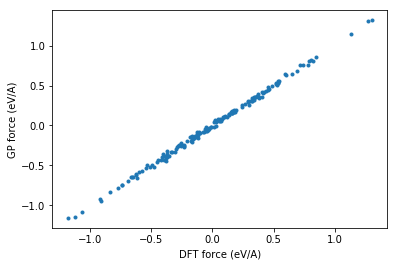

In [99]:
# plot GP versus DFT force
plt.plot(f_ts, f_preds, '.')
plt.xlabel('DFT force (eV/A)')
plt.ylabel('GP force (eV/A)')
plt.show()

In [95]:
print('mean error is '+str(np.mean(errs))+' eV.')

mean error is 0.01709322259150835 eV.


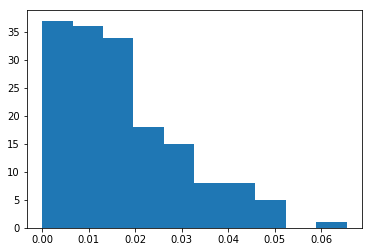

In [96]:
plt.hist(errs)
plt.show()

### Test model on single atom environment.

In [79]:
dists = np.linspace(1,10,100)
d = 1
fs = []
var_store = []
for n in range(len(dists)):
    dist = dists[n]  
    xt = np.array([[dist],[dist],[0],[0]])
    f, var = GP_pred(envs,fcs,K,L,alpha,sig,ls,xt,d)
    fs.append(f[0][0])
    var_store.append(var[0][0])

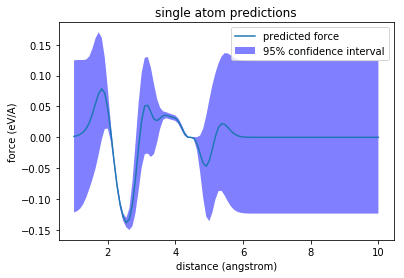

In [84]:
sigs = np.sqrt(var_store)
plt.plot(dists,fs,label='predicted force')
plt.fill(np.concatenate([dists, dists[::-1]]),
         np.concatenate([fs - 2*sigs,(fs+2*sigs)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.title('single atom predictions')
plt.xlabel('distance (angstrom)')
plt.ylabel('force (eV/A)')
plt.legend()
plt.show()

### Test model on all MD snapshots.

In [110]:
test_pts = np.arange(2,1000,10)

errs = []
stds = []
f_preds = []
f_ts = []

for n in range(len(test_pts)):
    # set test point
    test_pt = test_pts[n]
    pos_test = Si_MD_Parsed[test_pt]['positions']
    envs_test = get_envs(pos_test, brav_mat, brav_inv, vec1, vec2, vec3, cutoff)
    fcs_test = fc_conv(Si_MD_Parsed[test_pt+1]['forces'])
    
    # test on all components in the test point
    for m in range(54):
        at = m
        for p in range(3):
            d=p+1
            xt = envs_test[at]

            f, var = GP_pred(envs,fcs,K,L,alpha,sig,ls,xt,d)
            f_true = fcs_test[int(at*3+d-1)][0]*force_conv
            f_pred = f[0][0]*force_conv
            std_pred = np.sqrt(var[0][0])*force_conv
            err_true = np.abs(f_true-f_pred)

            errs.append(err_true)
            stds.append(std_pred)
            f_preds.append(f_pred)
            f_ts.append(f_true)
            
    print(n)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


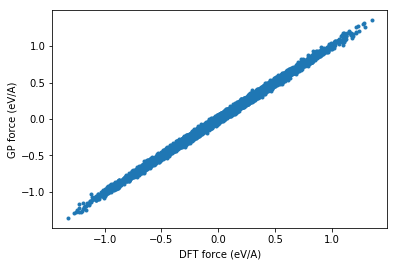

In [111]:
# plot GP versus DFT force
plt.plot(f_ts, f_preds, '.')
plt.xlabel('DFT force (eV/A)')
plt.ylabel('GP force (eV/A)')
plt.show()

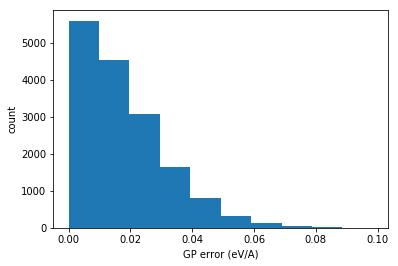

In [112]:
plt.hist(errs)
plt.xlabel('GP error (eV/A)')
plt.ylabel('count')
plt.show()

In [115]:
print('hyperparameters:')
print('noise std is '+str(noise*force_conv))
print('signal std is '+str(sig*force_conv))
print('length scale is '+str(ls))

hyperparameters:
noise std is 0.025861452697524344
signal std is 0.5360711347725317
length scale is 0.33739727


### See what happens when a one-component kernel is used on SiC data.

In [26]:
outfile ='/Users/jonpvandermause/Research/GP/Datasets/SiC_MD/sic_md.out'
Si_MD_Parsed = parse_qe_pwscf_md_output(outfile)

In [27]:
# set crystal structure
dim = 3
alat = 4.344404578
unit_cell = [[0.0, alat/2, alat/2], [alat/2, 0.0, alat/2], \
                    [alat/2, alat/2, 0.0]] # fcc primitive cell
unit_pos = [['Si',[0,0,0]],['Si',[alat/4, alat/4, alat/4]]]
brav_mat = np.array([[0.0, alat/2, alat/2], [alat/2, 0.0, alat/2], \
                    [alat/2, alat/2, 0.0]])*dim
brav_inv = np.linalg.inv(brav_mat)

# bravais vectors
vec1 = brav_mat[:,0].reshape(3,1)
vec2 = brav_mat[:,1].reshape(3,1)
vec3 = brav_mat[:,2].reshape(3,1)

In [28]:
# build force field from single snapshot
cutoff = 4.5
pos = Si_MD_Parsed[1]['positions']
envs = get_envs(pos, brav_mat, brav_inv, vec1, vec2, vec3, cutoff)
fcs = fc_conv(Si_MD_Parsed[2]['forces'])

# set optimal hyperparameters
sig = 0.02084984
ls = 0.33739727
noise = 0.00100585

In [29]:
# get K, L, and alpha
K,L=get_K(envs,sig,ls,noise)
alpha=get_alpha(K,L,fcs)

In [30]:
# get test environment
test_pt = 50
pos_test = Si_MD_Parsed[test_pt]['positions']
envs_test = get_envs(pos_test, brav_mat, brav_inv, vec1, vec2, vec3, cutoff)
fcs_test = fc_conv(Si_MD_Parsed[test_pt+1]['forces'])

In [31]:
# test on a single component
at = 50
d = 1
force_conv = 25.71104309541616 # Ry/au to eV/A

xt = envs_test[at]
f, var = GP_pred(envs,fcs,K,L,alpha,sig,ls,xt,d)
f_true = fcs_test[int(at*3+d-1)][0]
f_pred = f[0][0]
var_pred = np.sqrt(var[0][0])

print('predicted force component is '+str(f[0][0]*force_conv)+' eV/A.')
print('true force component is '+str(f_true*force_conv)+' eV/A.')
print('true error is '+str(np.abs(f_true-f_pred)*force_conv)+' eV/A.')
print('predicted std is '+str(var_pred*force_conv)+' eV/A.')
print('noise std is '+str(noise*force_conv)+' eV/A.')

predicted force component is -2.019410730672585 eV/A.
true force component is -2.326550123593532 eV/A.
true error is 0.3071393929209468 eV/A.
predicted std is 0.006219781086911899 eV/A.
noise std is 0.025861452697524344 eV/A.


In [32]:
# test on all components in the test point
errs = []
stds = []
f_preds = []
f_ts = []
for m in range(54):
    at = m
    for n in range(3):
        d=n+1
        xt = envs_test[at]
        
        f, var = GP_pred(envs,fcs,K,L,alpha,sig,ls,xt,d)
        f_true = fcs_test[int(at*3+d-1)][0]*force_conv
        f_pred = f[0][0]*force_conv
        std_pred = np.sqrt(var[0][0])*force_conv
        err_true = np.abs(f_true-f_pred)
        
        errs.append(err_true)
        stds.append(std_pred)
        f_preds.append(f_pred)
        f_ts.append(f_true)

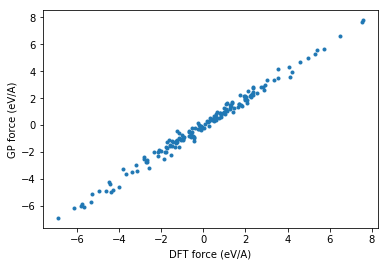

In [33]:
# plot GP versus DFT force
plt.plot(f_ts, f_preds, '.')
plt.xlabel('DFT force (eV/A)')
plt.ylabel('GP force (eV/A)')
plt.show()

In [34]:
print('mean error is '+str(np.mean(errs))+' eV.')

mean error is 0.20800222754016448 eV.


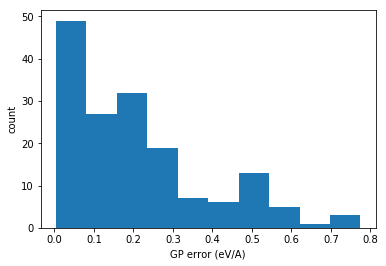

In [35]:
plt.hist(errs)
plt.xlabel('GP error (eV/A)')
plt.ylabel('count')
plt.show()